# KI-Group Workshop: Audio Classification

This is a workshop from Fabian Seipel and Corvin Jaedicke (TU Berlin, Audiotechnology and [hify.ai](https://hify.ai)). 
We will showcase a small example how to train a Deep Learning classifier on environmental sounds like siren, street_music, children_playing, dog_bark. These audio samples are a subset from the UrbanSound8k dataset (https://urbansounddataset.weebly.com/urbansound8k.html).

---

## Machine Learning x Audio

- Music Information Retrieval 
- Music Recommender Systems
- Automatic Music Transcription
- Blind source separation
- Audio Event Detection
- Speech Enhancement
- Speech Recognition

## Examples of Machine Learning Audio projects

- Lofi metal generation (GAN): https://www.youtube.com/watch?v=MwtVkPKx3RA
- Domestic AED: https://www.gierad.com/projects/listenlearner-automatic-class-discovery-and-one-shot-interactions-for-acoustic-activity-recognition/
- Song generation (Autoencoder): https://www.youtube.com/watch?v=UWxfnNXlVy8
- Google Magenta: https://magenta.tensorflow.org
- Magenta Transformer: https://magenta.github.io/listen-to-transformer/
- Magenta Tone Transfer: https://sites.research.google/tonetransfer
- SoNYC: https://wp.nyu.edu/sonyc/
- Bird sound classification: https://www.kaggle.com/c/birdsong-recognition
- Rainforest Connection Species Audio Detection: https://www.kaggle.com/c/rfcx-species-audio-detection
- Whale detection challenge: https://www.kaggle.com/c/whale-detection-challenge/data

---

## Colab preparations

If you want to use this notebook in colab, then execute the following steps. They are not necessary for usage in a local jupyter notebook or lab: 

1. Go to https://colab.research.google.com/drive/15KVrfYISUSk6kgWOgNvbJhRGvDrxcCYU#scrollTo=1YMSphWfjZm6
2. Clone the workshop repo: `git clone https://gitlab.com/ai-coustics-public/workshops/workshop-ki-group.git`
3. Change runtime to GPU
4. Tools -> Command palette -> Expand all sections 

---

## Install

In [4]:
!git clone https://gitlab.com/ai-coustics-public/workshops/workshop-ki-group.git
!mv -r workshop-ki-group/* ./
!pip install -r requirements.txt

Cloning into 'workshop-ki-group'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 27 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (27/27), done.
mv: cannot move 'workshop-ki-group/_audio' to './_audio': Directory not empty
mv: cannot move 'workshop-ki-group/_img' to './_img': Directory not empty


---

## 0. Imports

In [5]:
### import sklearn

# standard libraries
import sys
import os
import glob
import tqdm
import json
import itertools
from pathlib import Path

# external libraries
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as pd

import tensorflow as tf
from tensorflow import keras

import soundfile as sf
import librosa
from librosa import display


---

## 1. Download and explore the TinyUrbanSound8k dataset

In [6]:
# download the dataset using this neat keras function
download_link = 'https://gitlab.tubit.tu-berlin.de/dl4aed/dl4aed-data/raw/master/TinyUrbanSound8k/TinyUrbanSound8k.tar.gz'
filepath = keras.utils.get_file(Path('./_data/TinyUrbanSound8k.tar.gz').resolve(),
                                download_link,
                                cache_subdir=Path('./_data/').resolve(),
                                extract=True)

129335296/129321767 [==============================] - 59s 0us/step


In [7]:
# see the classes 
folders = glob.glob('_data/TinyUrbanSound8k/*/*/')
folders

['_data/TinyUrbanSound8k/train/street_music/',
 '_data/TinyUrbanSound8k/train/dog_bark/',
 '_data/TinyUrbanSound8k/train/siren/',
 '_data/TinyUrbanSound8k/train/children_playing/',
 '_data/TinyUrbanSound8k/test/street_music/',
 '_data/TinyUrbanSound8k/test/dog_bark/',
 '_data/TinyUrbanSound8k/test/siren/',
 '_data/TinyUrbanSound8k/test/children_playing/']

Show unique labels:

In [8]:
classes = sorted(set([Path(f).parts[-1] for f in folders]))
classes

['children_playing', 'dog_bark', 'siren', 'street_music']

Let's have a look at some random samples:

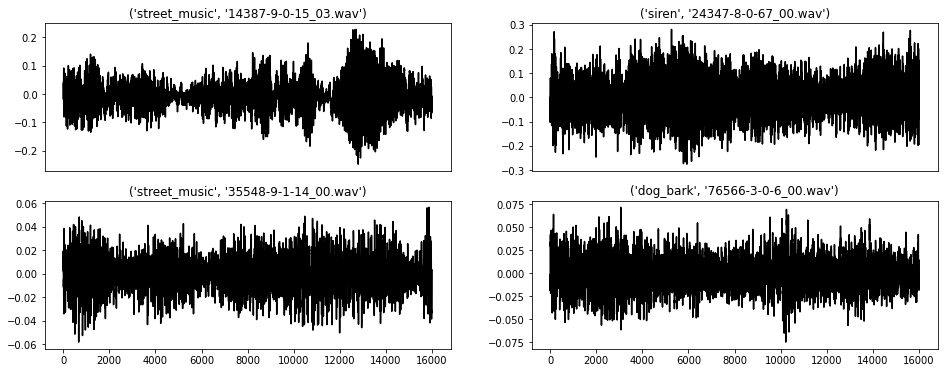

In [9]:
# get all wav files
fps = glob.glob('_data/TinyUrbanSound8k/**/*.wav', recursive=True)
fps_random = []
np.random.seed(9)

# setup subplot 
nrows, ncols = 2, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 6))

# plot some audio waveforms
for r in range(nrows):
    for c in range(ncols):
        fp_random = fps[np.random.randint(len(fps))]
        audio, sr = librosa.core.load(fp_random, sr=None)
        ax[r][c].plot(audio, c='k')
        ax[r][c].set_title(Path(fp_random).parts[-2:])
        if r == 0:
            ax[r][c].set_xticks([])
        # save random audio filepaths
        fps_random.append(fp_random)

In [10]:
# listen to the audio samples
for fp in fps_random:
    print(fp)
    pd.display(pd.Audio(fp))

_data/TinyUrbanSound8k/train/street_music/14387-9-0-15_03.wav


_data/TinyUrbanSound8k/test/siren/24347-8-0-67_00.wav


_data/TinyUrbanSound8k/train/street_music/35548-9-1-14_00.wav


_data/TinyUrbanSound8k/train/dog_bark/76566-3-0-6_00.wav


---

## 2. Spectrogram representations

Most digital audio signals are representing continuous air pressure signals, captured by transducers such as microphones. The analog to digital conversion both includes a quantization in time and amplitude. This transformation, called pulse code modulation, stores a signal with a defined sampling frequency and bit depth in uncompressed formats like WAVE. These one-dimensional representations contain only few information compared to their storage size. Most MIR tasks, especially for deep learning, involve the transformation of raw wave forms to two-dimensional time-frequency representations.

### 2.1. Short time fourier transform (STFT)

The most common spectrogram representation is the **Short Time Fourier Transform** (STFT) which indicates the time-varying energy across different frequency bands. STFTs are typically calculated for short periods of time, so called frames or windows of length N, to obtain the magnitude and phase information per frequency bin k for a certain time frame:

$$ X(k) = \sum_{n=0}^{N-1} w(n) \ x(n) \ e^{−j2πkn/N} $$

### 2.2. Mel scale

In order to adapt this representation to the human perception of pitch, the linear STFT bands can be post-precessed to obtain other scales such as the mel scale. Using a bandpass filterbank of M bands, the frequency f can be mapped to the corresponding mel band m:

$$ m(f) = 2595 \ {log}_{10} \ (1 + \frac{f}{700}) $$

The mel scale represents **perceptually equal pitch distances** according to human listeners. Underneath figure displays the mapping from Hertz to mel scale as well as a **triangular filter bank** for a spectrum conversion to 8 mel bands.

### 2.3. Calculating spectrograms

Several python libraries offer **STFT and Melspectrogram functions**, for example librosa. The mel spectrogram reduces the feature dimensionality (size of the spectrogram) by a factor defined by the ratio of fft bins to mel bins, and at the same time preserving most of the spectrogram information.  

Audio shape: (16000,)
Melspec shape: (64, 63)
Total data points in mel-spectrogram: 4032
Total data points in audio waveform: 16000
-> Data Reduction by factor: 3.9682539682539684



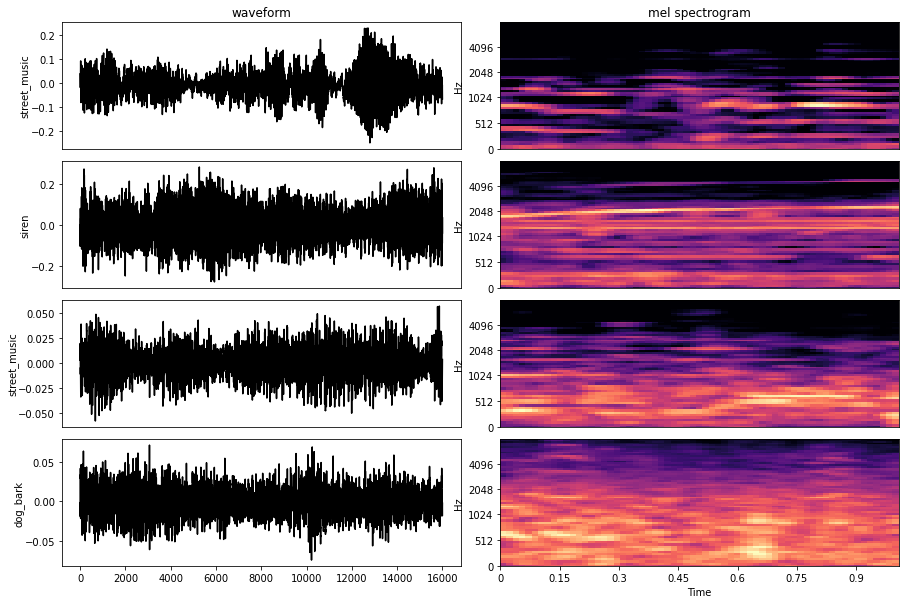

In [11]:
# setup subplot 
nrows, ncols = 4, 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

# plot some audio waveforms
for i, fp_random in enumerate(fps_random):
    audio, sr = librosa.core.load(fp_random, sr=None)
    
    # calculate melspec
    melspec = librosa.feature.melspectrogram(audio, n_fft=2048, hop_length=256, win_length=2048, n_mels=64, fmax=int(sr/2))
    melspec = librosa.amplitude_to_db(melspec, ref=np.max)

    # plot with librosa
    ax[i][0].plot(audio, c='k')
    librosa.display.specshow(melspec, x_axis='time', y_axis='mel', sr=sr, hop_length=256, ax=ax[i][1])
    
    # adjustments
    ax[i][0].set_ylabel(Path(fp_random).parts[-2], rotation=90, labelpad=0)
    
    # settings for all axises but bottom ones
    if not i == len(fps_random) - 1:
        ax[i][0].set_xticks([]), ax[i][1].set_xticks([])
        ax[i][0].set_xlabel(''), ax[i][1].set_xlabel('')
    
    # settings for upper axises
    if i == 0:
        ax[i][0].set_title('waveform')
        ax[i][1].set_title('mel spectrogram')   

# adjust whitespace in between subplots        
plt.subplots_adjust(hspace=0.1, wspace=0.1)

print('Audio shape: %s' % (str(audio.shape)))
print('Melspec shape: %s' % (str(melspec.shape)))
print(f'Total data points in mel-spectrogram: {melspec.shape[0]*melspec.shape[1]}')
print(f'Total data points in audio waveform: {audio.shape[0]}')
print(f'-> Data Reduction by factor: {(audio.shape[0]) / (melspec.shape[0]*melspec.shape[1])}')
print()

---

## 3. Preprocessing and TF Dataset


For the spectrograms calculation we need to define some parameters. Since we need those several times in the follwing functions and script, a best practice is to **collect all these parameters in a dictionary** and save it besides the features, so we have a reference when we reload the features for training.

In [12]:
# best-practice: write down your preprocessing config in a dictonary
config = {'sr': 16000, 
          'audio_length': 1,
          'mono': True,
          'n_mels': 64,
          'n_fft': 2048,
          'hop_length': 256,
          'win_length': 2048,
          'window': 'hann',
          'center': True,
          'classes': classes
         }

# save number of frames from length in samples divided by fft hop length
config['n_frames'] = int(config['sr']*config['audio_length']/config['hop_length']) + 1

# save input shape for model
config['input_shape'] = (config['n_mels'], config['n_frames'], 1)

# save config 
with open('_data/TinyUrbanSound8k/TinyUrbanSound8k_config.json', 'w+') as fp:
    json.dump(config, fp, sort_keys=True, indent=4)

# pretty print json
print(json.dumps(config, indent=4))

{
    "sr": 16000,
    "audio_length": 1,
    "mono": true,
    "n_mels": 64,
    "n_fft": 2048,
    "hop_length": 256,
    "win_length": 2048,
    "window": "hann",
    "center": true,
    "classes": [
        "children_playing",
        "dog_bark",
        "siren",
        "street_music"
    ],
    "n_frames": 63,
    "input_shape": [
        64,
        63,
        1
    ]
}


### 3.1. Preprocessing function wrapper

Getting *exotic* preprocessing into TensorFlow can be difficult, since we have to provide a computational graph compliant implementation. In the following example we make use of `tf.py_function()` to implement the librosa based preprocessing in a TensorFlow compliant way. This function allows to run arbitrary python code inside the computation graph. However, this step can pose challenges and there are even functions which can't be called at all inside a `tf.py_function()`. 

In [13]:
def folder_name_to_one_hot(file_path):
    
    # for example: _data/TinyUrbanSound8k/train/siren/157648-8-0-0_00.wav
    label = Path(file_path).parts[-2]
    label_idx = classes.index(label)
    
    # get one hot encoded array
    one_hot = tf.one_hot(label_idx, len(config['classes']), on_value=None, off_value=None, 
                         axis=None, dtype=tf.uint8, name=None)
    return one_hot


def load_and_preprocess_data(file_path):

    # path string is saved as byte array in tf.data.dataset -> convert back to str
    if type(file_path) is not str:
        file_path = file_path.numpy()
        file_path = file_path.decode('utf-8')

    # load audio data 
    audio, _ = librosa.core.load(file_path,
                                 sr=config['sr'],
                                 mono=True,
                                 # offset=0.0,
                                 # duration=None, 
                                 dtype=np.float32,
                                 res_type='kaiser_fast')

    # calculate melspec
    melspec = librosa.feature.melspectrogram(audio,
                                             n_fft=config['n_fft'],
                                             hop_length=config['hop_length'],
                                             win_length=config['win_length'],
                                             n_mels=config['n_mels'],
                                             fmax=int(sr/2))
    # scale amplitude dimension
    melspec = librosa.amplitude_to_db(melspec, ref=np.max)

    # add channel dimension for conv layer  compatibility
    melspec = np.expand_dims(melspec, axis=-1)
    
    # get ground truth from file_path string
    one_hot = folder_name_to_one_hot(file_path)
    
    return melspec, one_hot


def preprocessing_wrapper(file_path):
    mel_spec, one_hot = tf.py_function(load_and_preprocess_data, [file_path], [tf.float32, tf.uint8])
    mel_spec.set_shape([config['n_mels'], config['n_frames'], 1])
    one_hot.set_shape([len(config['classes'])])
    return mel_spec, one_hot


### 3.2. Create TF dataset from wav files

In order to create a Tensorflow Dataset, we first need to list all .wav files, then use our previously defined preprocessing function and finally batch and shuffle them. We'll do this process separately for the train and test set.  

In [14]:
# autotune computation
AUTOTUNE = tf.data.experimental.AUTOTUNE

# define a dataset of file paths
train_dataset = tf.data.Dataset.list_files('./_data/TinyUrbanSound8k/train/*/*.wav')
# run the preprocessing via map
train_dataset = train_dataset.map(preprocessing_wrapper, num_parallel_calls=AUTOTUNE)
# shuffle the data
train_dataset = train_dataset.shuffle(buffer_size=128)
# batch examples
train_dataset = train_dataset.batch(64)
# prefetch
train_dataset = train_dataset.prefetch(AUTOTUNE)


# define a dataset of file paths
test_dataset = tf.data.Dataset.list_files('./_data/TinyUrbanSound8k/test/*/*.wav')
# run the preprocessing via map
test_dataset = test_dataset.map(preprocessing_wrapper, num_parallel_calls=AUTOTUNE)
# batch examples
test_dataset = test_dataset.batch(64)
# prefetch
test_dataset = test_dataset.prefetch(AUTOTUNE)



Check if melspecs in dataset are correctly processed:

In [15]:
for element in train_dataset:
    print(f'Train feature shape: {element[0].shape}')
    print(f'Train label shape: {element[1].shape}')
    break

for element in test_dataset:
    print(f'Test feature shape: {element[0].shape}')
    print(f'Test label shape: {element[1].shape}')
    break

Train feature shape: (64, 64, 63, 1)
Train label shape: (64, 4)
Test feature shape: (64, 64, 63, 1)
Test label shape: (64, 4)


---

## 4. Introduction to Neural Networks

### 4.1. What is an Arfificial Neural Network?

A neural network is a computing model whose **layered structure** resembles the networked structure of neurons in the brain. It features interconnected processing elements called neurons that work together to produce an output function. Neural networks are made of **input and output** layers/dimensions, and in most cases, they also have a hidden layer consisting of units that transform the input into something that the output layer can use. Each neuron from a certain layer is connected to all neurons of the previous and the following layer by **weights** which resemble the strength of a connection between two neurons.

<a href="https://ibb.co/tcFwDkn"><img src="https://i.ibb.co/HY3Lq1R/fig-2-nn-weights.png" alt="fig-2-nn-weights" border="0"></a>

A neural network could for example being used to determine housing prices with a given dataset containing featuers of "size", "number of bedrooms", "zip code" and "wealth":

<a href="https://ibb.co/gVvstyG"><img src="https://i.ibb.co/6Bv6DY2/fig-2-nn-housing.png" alt="fig-2-nn-housing" border="0"></a>

### 4.2. How does a Neural Network learn? 

Neural networks learn (or are **trained**) by processing examples, each of which contains a known "input" (**feature**) and "result" (**label**), forming probability-weighted associations (**weights**) between the two, which are stored within the data structure of the net itself. The training of a neural network from a given example is usually conducted by determining the difference between the processed output of the network (often a prediction) and a target output. This is the **error** or **cost**. The network then adjusts its weights according to a **learning rule** and **optimiziation algorithm** by using this error value. Successive adjustments will cause the neural network to produce output which is increasingly similar to the target output. After a sufficient number of these adjustments the training can be terminated based upon certain criteria.

<a href="https://ibb.co/mXwM9kV"><img src="https://i.ibb.co/BrxSyb5/fig-2-nn-cost.png" alt="fig-2-nn-cost" border="0"></a>

### 4.3. Example of Training process

In case of the image MNIST image data, neurons in the input layer correspond to the 784 (28x28) pixel values of the corresponding image. The connections to the following layers resemble the weights in between the individual neurons. The lighter the neurons are shown, the more they are activated. At the beginning of the training process, all weights are initialized randomly, so the activations are relatively meaningless. Given those weights and activation, the class prediction in the output layer is far away from its actual label. The error in between prediction an label for this particular image is calculated by a loss function. Due to this error or loss, the network is updating its weights accordingly with a process called **Backpropagation**, which computes the gradient of the loss function with respect to the weights of the network for a single input–output example. The following optimization process of updating the networks' weights to minimize the loss function is called **Gradient Descent**. In every learning step the models performance gradually improves by showing the network a new image, comparing the networks output to the given labels and then adjusting the weights accordingly until a certain criteria is reached. The learning process is often carried out in **batches**, meaning that a several images are fed into the network and the loss and weights update is calculated as a mean over this batch of images.   

<a href="https://ibb.co/GHN3X2q"><img src="https://i.ibb.co/tLFPSs9/fig-2-3b1b.png" alt="fig-2-3b1b" border="0"></a>

Highly recommended videos from **3Blue1Brown** about Neural Networks:  
https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi

---

## 5. Model training

With tensorflow there's different methods of defining the model architecture. The easiest way is to use Tensorflow's Keras Functional or Sequential API: 

In [51]:
"""
Adapt normalization layer to input data.
This layer will shift and scale inputs into a distribution 
centered around 0 with standard deviation 1. It accomplishes this by 
precomputing the mean and variance of the data, 
and calling (input - mean) / sqrt(var) at runtime.
The mean and variance values for the layer must be either supplied 
on construction or learned via adapt()
"""
norm_layer = tf.keras.layers.Normalization(axis=None)

norm_dataset = train_dataset.take(20)
norm_dataset = norm_dataset.map(lambda x, y: x)
norm_layer.adapt(norm_dataset)

In [52]:
print(norm_layer.variance)
print(norm_layer.mean)

tf.Tensor([[[[416.062]]]], shape=(1, 1, 1, 1), dtype=float32)
tf.Tensor([[[[-58.592186]]]], shape=(1, 1, 1, 1), dtype=float32)


In [67]:

# Spectrogram data motivated basic sequential Recurrent-CNN
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=config['input_shape']))

model.add(norm_layer)
model.add(tf.keras.layers.Permute((2, 1, 3)))

model.add(tf.keras.layers.Conv2D(
    16, (3, 3), activation="elu", kernel_initializer='he_normal'))
model.add(tf.keras.layers.GaussianDropout(0.1))

model.add(tf.keras.layers.Conv2D(
    64, (15, 1), activation="elu", kernel_initializer='he_normal'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 1)))
model.add(tf.keras.layers.GaussianDropout(0.1))

model.add(tf.keras.layers.Conv2D(
    64, (1, 15), activation="elu", kernel_initializer='he_normal'))
model.add(tf.keras.layers.MaxPool2D(pool_size=(1, 2)))
model.add(tf.keras.layers.GaussianDropout(0.1))

model.add(tf.keras.layers.Conv2D(
    32, (3, 3), activation="elu", kernel_initializer='he_normal'))


# (None, 22, 21, 32)  -> (None, 22, 672)
model.add(tf.keras.layers.Reshape((22, 672)))
model.add(tf.keras.layers.LSTM(64))

model.add(tf.keras.layers.Dense(len(config['classes']), activation="softmax"))

model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_3 (Normalizat  (None, 64, 63, 1)        3         
 ion)                                                            
                                                                 
 permute_1 (Permute)         (None, 63, 64, 1)         0         
                                                                 
 conv2d_36 (Conv2D)          (None, 61, 62, 16)        160       
                                                                 
 gaussian_dropout_27 (Gaussi  (None, 61, 62, 16)       0         
 anDropout)                                                      
                                                                 
 conv2d_37 (Conv2D)          (None, 47, 62, 64)        15424     
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 23, 62, 64)     

In [75]:
# compile model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# fit model
model.fit(train_dataset, epochs=15)

Epoch 1/10
63/63 [==============================] - 42s 604ms/step - loss: 0.3199 - accuracy: 0.8892
Epoch 2/10
63/63 [==============================] - 39s 608ms/step - loss: 0.2576 - accuracy: 0.9160
Epoch 3/10
63/63 [==============================] - 40s 611ms/step - loss: 0.2150 - accuracy: 0.9342
Epoch 4/10
63/63 [==============================] - 39s 607ms/step - loss: 0.1984 - accuracy: 0.9405
Epoch 5/10
63/63 [==============================] - 38s 592ms/step - loss: 0.1534 - accuracy: 0.9603
Epoch 6/10
63/63 [==============================] - 39s 601ms/step - loss: 0.1246 - accuracy: 0.9710
Epoch 7/10
63/63 [==============================] - 39s 606ms/step - loss: 0.1098 - accuracy: 0.9728
Epoch 8/10
63/63 [==============================] - 39s 600ms/step - loss: 0.0881 - accuracy: 0.9825
Epoch 9/10
63/63 [==============================] - 39s 596ms/step - loss: 0.0654 - accuracy: 0.9895
Epoch 10/10
63/63 [==============================] - 39s 594ms/step - loss: 0.0477 - accura

---

## 6. Evaluation and results

In order to place our results, there's different methods and metrics to investigate.

### 6.1. Get accuracy and loss on testset

Next, compare how the model performs on the test dataset:

In [76]:
test_loss, test_acc = model.evaluate(test_dataset, verbose=2)
print('\nTest accuracy:', test_acc)

13/13 - 8s - loss: 0.6580 - accuracy: 0.7738 - 8s/epoch - 588ms/step

Test accuracy: 0.7737500071525574


It turns out that the accuracy on the test dataset is a little less than the accuracy on the training dataset. This gap between training accuracy and test accuracy represents *overfitting*. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data.

### 6.2. Confusion Matrix

A confusion matrix is a technique for summarizing the performance of a classification algorithm. Classification accuracy alone can be misleading if you have an unequal number of observations in each class or if you have more than two classes in your dataset. Calculating a confusion matrix can give you a better idea of what your classification model is getting right and what types of errors it is making. Here's a function to plot the confusion matrix:

In [77]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label'), plt.xlabel('Predicted label')

Let's first predict our test samples, get the individual probability and then argmax those probabilities to see the predictions: 

Normalized confusion matrix


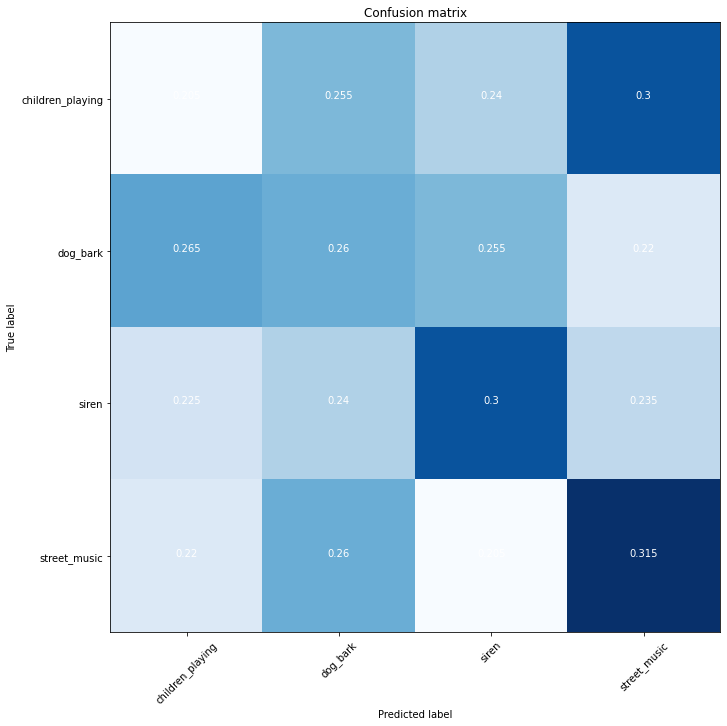

In [80]:
# get predictions and labels as arrays
y_test_prob = model.predict(test_dataset)
y_test_pred = np.argmax(y_test_prob, axis=1)
y_test_true = np.argmax(np.array([y for x, y in test_dataset.unbatch().as_numpy_iterator()]), axis=1)

# call confusion matrix
cm = tf.math.confusion_matrix(labels=y_test_true, predictions=y_test_pred)
cm = cm.numpy()
plot_confusion_matrix(cm, classes=config['classes'], normalize=True, title='Confusion matrix', cmap=plt.cm.Blues)

---

## 7. Predict on real data
We have now trained our model and saved the parameters. We can use this to now see what the model would predict on real data.

### 7.1. Detecting an Ambulance Siren in Lisboa

In [72]:
# listen to a beautiful Lisboa ambulance siren
pd.display(pd.Audio('_audio/lisboa_siren.wav'))


In [73]:
# modified prepocessing for inference
def load_and_preprocess(file_path, offset=0.0):

    # load audio data 
    audio, _ = librosa.core.load(file_path,
                                 sr=config['sr'],
                                 mono=True,
                                 offset=offset,
                                 duration=1, 
                                 dtype=np.float32,
                                 res_type='kaiser_fast')

    # calculate melspec
    melspec = librosa.feature.melspectrogram(audio,
                                             n_fft=config['n_fft'],
                                             hop_length=config['hop_length'],
                                             win_length=config['win_length'],
                                             n_mels=config['n_mels'],
                                             fmax=int(sr/2))
    # scale amplitude dimension
    melspec = librosa.amplitude_to_db(melspec, ref=np.max)

    # add channel dimension for conv layer  compatibility
    melspec = np.expand_dims(melspec, axis=-1)
    # add empty batch dimension
    melspec = np.expand_dims(melspec, axis=0)
    
    return melspec

In [79]:
# load and preproces recording
lisboa_siren_spec = load_and_preprocess('_audio/lisboa_siren.wav', offset=0.5)

# run inference
prediction = model(lisboa_siren_spec)

print('='*10)
print(f'Detected: {classes[np.argmax(prediction)]}')

Detected: siren


---

---

# END

---

---

### Further reading and resources:

#### UrbanSound8k dataset:  
https://urbansounddataset.weebly.com/urbansound8k.html


#### TF data pipelines:
https://www.tensorflow.org/guide/data


#### Coursera courese ...

---